# Open311 Classifier
Find within some exploration of the Open311DataSet and some classification experiments

In [1]:
#%reset
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 

DATA_FOLDER = './data/'
reports = pd.read_csv(os.path.join(DATA_FOLDER, 'Open311DataFixed.csv'))
reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92286 entries, 0 to 92285
Data columns (total 13 columns):
service_request_id    92286 non-null int64
requested_datetime    92286 non-null object
updated_datetime      92286 non-null object
closed_date           92286 non-null object
status                92286 non-null object
source                58419 non-null object
service_name          92286 non-null object
service_subtype       0 non-null float64
description           84009 non-null object
agency_responsible    24915 non-null object
address               86808 non-null object
lat                   74468 non-null float64
long                  74470 non-null float64
dtypes: float64(3), int64(1), object(9)
memory usage: 9.2+ MB


Of particular interest is the 'description' column. No doubt location, date, and time info could prove useful. First we just use text.

In [2]:
reports['service_name'].value_counts()

Trash                                 40683
Recycling                             18613
Excessive Growth                       6863
Yard Waste                             4602
Other                                  2556
Potholes, Other Street Repair          2020
Temporary Signage w/o permit           1730
Sewer Problems (Sanitary Sewers)       1467
Water Utility Problems                 1358
Sidewalk Snow Removal                  1297
Parking on Unimproved Surface          1009
Street Lights                           922
Graffiti                                749
Water Quality                           730
Traffic Related Complaints              654
Street Snow Removal                     635
Line of Sight                           572
Blocked Street                          558
Traffic Signals                         503
Website & Mobile Apps Feedback          451
Sidewalk & Curb Complaints              444
Parks & Playgrounds                     396
Unsafe Buildings                

In [5]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
#nltk.download() # kicks off a GUI thing - do we always need?
from nltk.stem.snowball import SnowballStemmer
# try other (or no?) stemmers?
stemmer = SnowballStemmer("english", ignore_stopwords=False) # True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

Oh snap. lots of NaN descriptions. That's no help!
Do your data massaging here

In [6]:
"""
how's about a season feature?
Yes, we are using numbers. it does happen in order, but could do this using 2 features
to capture the cyclical nature

SPRING EQUINOX	March 20, 12:15 P.M. EDT 0
SUMMER SOLSTICE	June 21, 6:07 A.M. EDT 1
FALL EQUINOX	September 22, 9:54 P.M. EDT 2
WINTER SOLSTICE	December 21, 5:23 P.M. EST 3

oops, I didn't include time below, slap me
"""
from datetime import datetime

def get_season(in_date):
    if in_date.month == 12 and in_date.day >= 21:
        return 3
    elif (in_date.month >= 9 and in_date.day >= 22) or in_date.month > 9:
        return 2
    elif (in_date.month >= 6 and in_date.day >= 21) or in_date.month > 6:
        return 1
    elif (in_date.month >= 3 and in_date.day >= 20) or in_date.month > 3:
        return 0
    else:
        return 3

def date_to_nth_day(date):
    new_year_day = datetime(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1
    
reports['parsed_requested_datetime'] = pd.to_datetime(reports['requested_datetime'])
reports['season'] = reports['parsed_requested_datetime'].apply(get_season)
reports['day_of_year'] = reports['parsed_requested_datetime'].apply(date_to_nth_day)
goodreports = reports[(pd.notnull(reports['description']))]
x=goodreports['description']
goodreports['service_name'].value_counts()
goodreports.info()

season = goodreports['season']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84009 entries, 0 to 92285
Data columns (total 16 columns):
service_request_id           84009 non-null int64
requested_datetime           84009 non-null object
updated_datetime             84009 non-null object
closed_date                  84009 non-null object
status                       84009 non-null object
source                       56819 non-null object
service_name                 84009 non-null object
service_subtype              0 non-null float64
description                  84009 non-null object
agency_responsible           21476 non-null object
address                      78549 non-null object
lat                          66779 non-null float64
long                         66781 non-null float64
parsed_requested_datetime    84009 non-null datetime64[ns]
season                       84009 non-null int64
day_of_year                  84009 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(3), object(9)
memory usage

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6095 entries, 24 to 92285
Data columns (total 16 columns):
service_request_id           6095 non-null int64
requested_datetime           6095 non-null object
updated_datetime             6095 non-null object
closed_date                  6095 non-null object
status                       6095 non-null object
source                       5159 non-null object
service_name                 6095 non-null object
service_subtype              0 non-null float64
description                  6095 non-null object
agency_responsible           2629 non-null object
address                      5795 non-null object
lat                          4456 non-null float64
long                         4456 non-null float64
parsed_requested_datetime    6095 non-null datetime64[ns]
season                       6095 non-null int64
day_of_year                  6095 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(3), object(9)
memory usage: 809.5+ KB
<cl

(array([414., 367.,  68., 110.,  73., 267.,  71.,  65.,  38., 262.]),
 array([  1. ,  37.5,  74. , 110.5, 147. , 183.5, 220. , 256.5, 293. ,
        329.5, 366. ]),
 <a list of 10 Patch objects>)

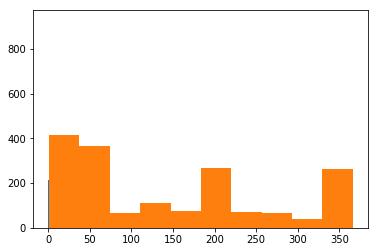

In [7]:
# explore, see if there's some relation
xgrow = goodreports[goodreports['service_name'] == 'Excessive Growth']
xgrow.info()
#plt.hist(xgrow['season'])
# mainly zero or 1 - spring and summer, makes sense

trash = goodreports[goodreports['service_name'] == 'Trash']
xgrow.info()
#plt.hist(trash['season'])
# kind of even split.

# but what about the whole deal
#plt.hist(goodreports['season'])
# sort of even

# we would expect these
snow = goodreports[goodreports['service_name'].isin(['Sidewalk Snow Removal','Street Snow Removal'])]
plt.hist(snow['season'])

# the words might be overpowering this anyways
# mostly winter. Why some in summer?

plt.hist(snow['day_of_year'])

# a bunch on the 200th day of the year wut?
# storm and draingage stuff. This data needs some luv

In [8]:
weird_snow = snow[(snow['day_of_year'] > 175) & (snow['day_of_year'] < 225)]
weird_snow.info()
weird_snow.head(50)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 8469 to 81672
Data columns (total 16 columns):
service_request_id           300 non-null int64
requested_datetime           300 non-null object
updated_datetime             300 non-null object
closed_date                  300 non-null object
status                       300 non-null object
source                       251 non-null object
service_name                 300 non-null object
service_subtype              0 non-null float64
description                  300 non-null object
agency_responsible           3 non-null object
address                      299 non-null object
lat                          100 non-null float64
long                         100 non-null float64
parsed_requested_datetime    300 non-null datetime64[ns]
season                       300 non-null int64
day_of_year                  300 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(3), object(9)
memory usage: 39.8+ KB


,service_request_id,requested_datetime,updated_datetime,closed_date,status,source,service_name,service_subtype,description,agency_responsible,address,lat,long,parsed_requested_datetime,season,day_of_year
8469,40368,2003-07-08T05:00:00-05:00,2016-09-11T22:02:05-04:00,2003-07-08T05:00:00-05:00,closed,Letter,Sidewalk Snow Removal,NaN,Mike called to report a large hole in the pave...,NaN,"E 11TH ST, Bloomington, IN",NaN,NaN,2003-07-08 10:00:00,1,189
9350,43384,2002-08-12T05:00:00-05:00,2016-09-11T22:02:05-04:00,2002-08-12T05:00:00-05:00,closed,Phone Call,Sidewalk Snow Removal,NaN,CLOGGED STORM DRAIN,NaN,"N SMITH, Bloomington, IN",NaN,NaN,2002-08-12 10:00:00,1,224
9402,43613,2002-07-29T05:00:00-05:00,2016-09-11T22:02:05-04:00,2002-07-29T05:00:00-05:00,closed,Phone Call,Sidewalk Snow Removal,NaN,DRAINAGE AREA IS SUNKEN IN,NaN,"3600 N Prow RD, Bloomington, IN, 47404",39.206005,-86.551163,2002-07-29 10:00:00,1,210
9409,43630,2002-07-29T05:00:00-05:00,2016-09-11T22:02:05-04:00,2002-07-29T05:00:00-05:00,closed,Phone Call,Sidewalk Snow Removal,NaN,CLEAN INLET,NaN,"400 S Swain AVE, Bloomington, IN, 47401",39.162972,-86.515366,2002-07-29 10:00:00,1,210
9450,43750,2002-07-17T05:00:00-05:00,2016-09-11T22:02:05-04:00,2002-07-17T05:00:00-05:00,closed,Phone Call,Sidewalk Snow Removal,NaN,Standing water in yard of old house next door;...,NaN,"1753 S Park AVE, Bloomington, IN, 47401",39.147457,-86.524071,2002-07-17 10:00:00,1,198
9479,43891,2002-07-05T05:00:00-05:00,2016-09-11T22:02:05-04:00,2002-07-05T05:00:00-05:00,closed,Phone Call,Sidewalk Snow Removal,NaN,STORM DRAIN IS CLOGGED,NaN,"1300 E 3rd ST, Bloomington, IN",NaN,NaN,2002-07-05 10:00:00,1,186
9480,43895,2002-07-05T05:00:00-05:00,2016-09-11T22:02:05-04:00,2002-07-05T05:00:00-05:00,closed,Phone Call,Sidewalk Snow Removal,NaN,STORM DITCH IN FRONT OF HOUSE NEEDS WORK ON IT,NaN,"1013 S Washington ST, Bloomington, IN, 47401",39.154404,-86.532280,2002-07-05 10:00:00,1,186
9482,43898,2002-07-05T05:00:00-05:00,2016-09-11T22:02:05-04:00,2002-07-05T05:00:00-05:00,closed,Phone Call,Sidewalk Snow Removal,NaN,"STORM SEWER PIPE MAY BE DAMAGED, WILL SEE SINK...",NaN,"1618 E GREENFIELD, Bloomington, IN",NaN,NaN,2002-07-05 10:00:00,1,186
9483,43900,2002-07-05T05:00:00-05:00,2016-09-11T22:02:05-04:00,2002-07-05T05:00:00-05:00,closed,Phone Call,Sidewalk Snow Removal,NaN,CUSTOMER SAYS HE NEEDS DRAINING DITCHES IN FRO...,NaN,"1924 E Viva DR, Bloomington, IN, 47401",39.152451,-86.509911,2002-07-05 10:00:00,1,186
9496,43922,2002-07-05T05:00:00-05:00,2016-09-11T22:02:05-04:00,2002-07-05T05:00:00-05:00,closed,Phone Call,Sidewalk Snow Removal,NaN,STORM DRAIN IS CLOGGED,NaN,"827 W 11th ST, Bloomington, IN, 47404",39.173157,-86.543564,2002-07-05 10:00:00,1,186


In [9]:
from sklearn import preprocessing
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
# above fixes this REALLY DUMB thing: 
# https://stackoverflow.com/questions/48687375/deprecation-error-in-sklearn-about-empty-array-without-any-empty-array-in-my-cod
y=goodreports['service_name']

In [10]:
from sklearn.linear_model import LogisticRegression

# use df as train set
# do da splits 33 for test? 25 is better?
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(goodreports['description'], y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(goodreports, y, test_size=0.33, random_state=42)

### Solver notes

In reading it was found liblinear is really slow, lbfgs is faster at a slight accuracy cost.

'The “sag” solver uses a Stochastic Average Gradient descent [6]. It is faster than other solvers for large datasets, when both the number of samples and the number of features are large.'

Trying lbfgs, it is indeed slow! sag comes back in under 40 seconds.
lbfgs: CPU times: user 8min 4s, sys: 21.9 s, total: 8min 26s - 79.59 acc tho
let's 'pickle it!'

In [11]:
%%time
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import TruncatedSVD

"""
http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html

didn't converge in 300 (in 3 min) with season and doy

try maybe chaining instead - given probabilities from classifier one plus these other things, pick one
"""

def get_description(df):
    return df['description']

# weird reshaping
# parametrize these better

def get_season(df):
    return np.array(df['season']).reshape(-1, 1)

def get_day_of_year(df):
    return np.array(df['day_of_year']).reshape(-1, 1)

multi_class = 'multinomial'   #'ovr' # other option is 'multinomial'

# ngram range 8/30/2018
# first one works, second one works, both together? nope
text_clf_logreg = \
Pipeline([
 ('features', FeatureUnion([
    ('ngram_tf_idf', Pipeline([
      ('texty', FunctionTransformer(get_description, validate = False)),
      ('counts', CountVectorizer(ngram_range=(1, 2))),
      ('tf_idf', TfidfTransformer())
    ])),
        
   # ('season', FunctionTransformer(get_season, validate = False)),
   # ('day_of_year', FunctionTransformer(get_day_of_year, validate = False)),
    
    ])),  
 ('clf-lr', LogisticRegression(solver='sag', max_iter=1000, 
                            random_state=42,
                             multi_class=multi_class)),
                         ])

_ = text_clf_logreg.fit(X_train, y_train)
predicted_logreg = text_clf_logreg.predict(X_test)
print(np.mean(predicted_logreg == y_test))
# max_iter can be used to get shorter test cycles - takes about 36 sec out of the box

0.8051437434621073
CPU times: user 25.4 s, sys: 742 ms, total: 26.1 s
Wall time: 27.3 s


In [19]:
#from sklearn.externals import joblib
#joblib.dump(text_clf_logreg, 'open311lbfgs.pkl') 
# pickled package is 100MB!

In [12]:
# play time - how to extract MODEL from pipeline
text_clf_logreg.named_steps
classifier = text_clf_logreg.named_steps['clf-lr']
print(classifier.coef_) # good luck understanding that!
print(classifier.coef_.shape) # - 207828 (words)
#print(dir(classifier))
print(classifier.classes_)
print(classifier.n_iter_) # only 38, w00t # 296 with season in it

[[-4.57740558e-02 -3.71068680e-04 -8.15957333e-04 ... -5.85045102e-04
  -1.15887680e-03 -1.15887680e-03]
 [-4.43740976e-03 -3.57263742e-05 -8.02267502e-05 ... -5.85888284e-05
  -1.08486446e-04 -1.08486446e-04]
 [ 1.95840935e-02 -6.02494335e-04 -2.11304485e-03 ... -1.13233210e-03
  -1.72946989e-03 -1.72946989e-03]
 ...
 [ 1.58453338e-01 -7.96330964e-04 -1.91684405e-03 ... -1.83695127e-03
  -5.90841286e-03 -5.90841286e-03]
 [-4.67087938e-02 -9.86996748e-04 -2.64558065e-03 ... -2.28912486e-03
  -4.03421534e-03 -4.03421534e-03]
 [ 2.40724667e-01 -6.44435061e-04 -4.01432749e-03 ... -4.41137728e-03
  -2.08091126e-02 -2.08091126e-02]]
(52, 209327)
['Abandoned Vehicle' 'Accessibility Problem' 'Animal Control'
 'Biking & Walking' 'Blocked Street' 'Blocked sidewalk'
 'Bus Services (Bloomington Transit)' 'Business' 'City Performance'
 'Crow Sightings' 'Drainage or Runoff' 'Excessive Growth' 'Fire Hazards'
 'Graffiti' 'Inaccessible Parking' 'Leaf Collection' 'Line of Sight'
 'Open311 API Key Reque

In [29]:
print(X_test.iloc[3],predicted_logreg[3])
X_test.info()
#bumpup = pd.DataFrame({"description":X_test, "prediction":predicted_logreg})
# add cat map
#bumpup.head(200)

service_request_id                                             123133
requested_datetime                          2011-08-29T18:02:23-04:00
updated_datetime                            2016-09-11T22:02:05-04:00
closed_date                                 2011-08-30T09:22:10-04:00
status                                                         closed
source                                                            NaN
service_name                                                Recycling
service_subtype                                                   NaN
description                                       not properly sorted
agency_responsible                                                NaN
address                      1718 E Circle DR, Bloomington, IN, 47401
lat                                                            39.155
long                                                         -86.5127
parsed_requested_datetime                         2011-08-29 22:02:23
season              

In [32]:
# revisit, was testing
#pp = text_clf_logreg.predict_proba(['snow on the sidewalk'])
#print(classifier.classes_[np.argmax(pp)])
#print(pp[0][np.argmax(pp)])
#probtab = pd.DataFrame({"class":list(classifier.classes_),"prob":pp[0]})
#probtab

In [33]:
from sklearn import metrics

clf = text_clf_logreg
pred = predicted_logreg
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
print("classification report:")
print(metrics.classification_report(y_test, pred)) 
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, pred))

accuracy:   0.805
classification report:
                                    precision    recall  f1-score   support

                 Abandoned Vehicle       0.57      0.10      0.17        41
             Accessibility Problem       0.00      0.00      0.00         3
                    Animal Control       1.00      0.19      0.32        64
                  Biking & Walking       0.73      0.11      0.18        76
                    Blocked Street       0.45      0.20      0.27       157
                  Blocked sidewalk       0.00      0.00      0.00        63
Bus Services (Bloomington Transit)       0.00      0.00      0.00         8
                          Business       0.00      0.00      0.00        19
                  City Performance       0.00      0.00      0.00        62
                    Crow Sightings       0.00      0.00      0.00         1
                Drainage or Runoff       0.00      0.00      0.00        50
                  Excessive Growth       0.74 

/Users/scharlesworth/.pyenv/versions/3.6.3/envs/open-311-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
pd.set_option('display.max_colwidth', -1)
goodreports[goodreports["service_name"] == 'Sidewalk Snow Removal']['description']

55838    Storm water has broken concrete and asphalt draining under street. Two small holes on either side of inlet. The drain elevation is also a problem on other end.                                                                                                                                                                                                                                                                                                                                                                              
55839    will not comply and use stickers.  i sent them a letter on 5/4 letting them know that if they did not comply then they would be turned over to you, so i am turning them over to you.  no stickers again today.                                                                                                                                                                                                                                                         

In [16]:
stuff = reports[reports['service_name'] == 'Crow Sightings'] # or 'Abandoned Vehicle'
stuff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 87121 to 90640
Data columns (total 16 columns):
service_request_id           3 non-null int64
requested_datetime           3 non-null object
updated_datetime             3 non-null object
closed_date                  3 non-null object
status                       3 non-null object
source                       3 non-null object
service_name                 3 non-null object
service_subtype              0 non-null float64
description                  2 non-null object
agency_responsible           3 non-null object
address                      3 non-null object
lat                          3 non-null float64
long                         3 non-null float64
parsed_requested_datetime    3 non-null datetime64[ns]
season                       3 non-null int64
day_of_year                  3 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(3), object(9)
memory usage: 408.0+ bytes


In [17]:
stuff['description']

87121                                                  NaN
90235    crows had attacked the back parking lot early ...
90640    Crows roosted October 23-February 16. We are s...
Name: description, dtype: object

Let's get confused - below is from scikit-learn docs. Also, it looks like shit!

Confusion matrix, without normalization
[[12046   108     4     1     1     1]
 [  979  4131     0     0     0     5]
 [   30     4   535     0     0     0]
 [   33     3     4   353     0     0]
 [   12     1     4     0   279     0]
 [   35     1     2     0     2   159]]
Normalized confusion matrix
[[9.91e-01 8.88e-03 3.29e-04 8.22e-05 8.22e-05 8.22e-05]
 [1.91e-01 8.08e-01 0.00e+00 0.00e+00 0.00e+00 9.78e-04]
 [5.27e-02 7.03e-03 9.40e-01 0.00e+00 0.00e+00 0.00e+00]
 [8.40e-02 7.63e-03 1.02e-02 8.98e-01 0.00e+00 0.00e+00]
 [4.05e-02 3.38e-03 1.35e-02 0.00e+00 9.43e-01 0.00e+00]
 [1.76e-01 5.03e-03 1.01e-02 0.00e+00 1.01e-02 7.99e-01]]


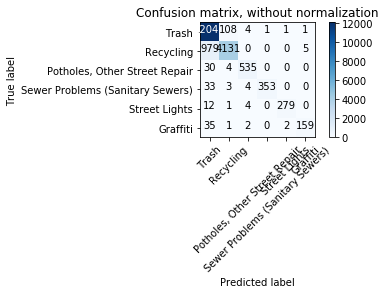

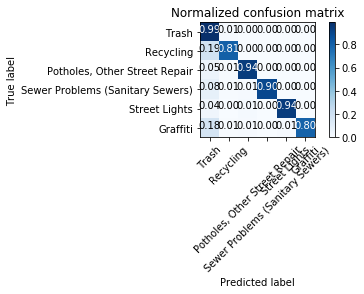

In [18]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix - try w/ subset of things?
#cnf_matrix = confusion_matrix(y_test, y_pred)

c_names = ['Trash','Recycling',
           'Potholes, Other Street Repair',
           'Sewer Problems (Sanitary Sewers)',
          'Street Lights',
          'Graffiti']

cnf_matrix = metrics.confusion_matrix(y_test, pred, labels = c_names)
np.set_printoptions(precision=2)

class_names = c_names # classifier.classes_
# make these deals BIGGER
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [34]:
#baddies = X_test[predicted_logreg != y_test]
#baddies_check = pd.DataFrame({"desc": baddies, "predict": predicted_logreg[predicted_logreg != y_test], "actual": y_test[predicted_logreg != y_test]})
#baddies_check.head(100)
#wait why NaN in there?!?!?

In [35]:
goodreports['service_name'].value_counts()

Trash                                 37424
Recycling                             15751
Excessive Growth                       6095
Yard Waste                             3787
Other                                  2460
Potholes, Other Street Repair          1971
Temporary Signage w/o permit           1724
Sewer Problems (Sanitary Sewers)       1460
Water Utility Problems                 1354
Sidewalk Snow Removal                  1167
Parking on Unimproved Surface           975
Street Lights                           916
Water Quality                           730
Graffiti                                690
Traffic Related Complaints              649
Street Snow Removal                     568
Blocked Street                          548
Line of Sight                           543
Traffic Signals                         501
Website & Mobile Apps Feedback          442
Sidewalk & Curb Complaints              429
Parks & Playgrounds                     394
Sewer Problems (Storm Sewers)   